The Sun Also Rises (1926)
http://gutenberg.ca/ebooks/hemingwaye-sunalsorises/hemingwaye-sunalsorises-00-h.html

Men Without Women (1927) 
http://gutenberg.ca/ebooks/hemingwaye-menwithoutwomen/hemingwaye-menwithoutwomen-00-h.html

Winner Take Nothing (1933)
http://gutenberg.ca/ebooks/hemingwaye-winnertakenothing/hemingwaye-winnertakenothing-00-h.html

Green Hills of Africa (1935)
http://gutenberg.ca/ebooks/hemingwaye-greenhillsofafrica/hemingwaye-greenhillsofafrica-00-h.html

Across the River and Into the Trees (1950) 
http://gutenberg.ca/ebooks/hemingwaye-acrosstheriver/hemingwaye-acrosstheriver-00-h.html

The Old Man and the Sea (1952)
http://gutenberg.ca/ebooks/hemingwaye-oldmanandthesea/hemingwaye-oldmanandthesea-00-h.html

In [1]:
# Web Scraping
import requests
from bs4 import BeautifulSoup

# Preprocess
import spacy
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd

# EDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koalachelsea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/koalachelsea/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Web Scraping using BeautifulSoup

In [2]:
url = 'http://gutenberg.ca/ebooks/hemingwaye-sunalsorises/hemingwaye-sunalsorises-00-h.html'
res = requests.get(url)
html_page = res.content

soup = BeautifulSoup(html_page, 'html.parser')

text = soup.find_all(text=True)

set([t.parent.name for t in text])

{'[document]',
 'a',
 'b',
 'blockquote',
 'body',
 'div',
 'h1',
 'h2',
 'h3',
 'h4',
 'head',
 'html',
 'i',
 'p',
 'small',
 'title'}

In [3]:
output = ''
for t in text:
    if t.parent.name in ['p']:
        output += '{} '.format(t)
output

'\nRobert Cohn was once middleweight boxing champion of Princeton. Do not\nthink that I am very much impressed by that as a boxing title, but it\nmeant a lot to Cohn. He cared nothing for boxing, in fact he disliked\nit, but he learned it painfully and thoroughly to counteract the feeling\nof inferiority and shyness he had felt on being treated as a Jew at\nPrinceton. There was a certain inner comfort in knowing he could knock\ndown anybody who was snooty to him, although, being very shy and a\nthoroughly nice boy, he never fought except in the gym. He was Spider\nKelly\'s star pupil. Spider Kelly taught all his young gentlemen to box\nlike featherweights, no matter whether they weighed one hundred and five\nor two hundred and five pounds. But it seemed to fit Cohn. He was really\nvery fast. He was so good that Spider promptly overmatched him and got\nhis nose permanently flattened. This increased Cohn\'s distaste for\nboxing, but it gave him a certain satisfaction of some strange sort

In [4]:
def Web_Scraping(url):
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    output = ''
    for t in text:
        if t.parent.name in ['p']:
            output += '{} '.format(t)
    output = output.strip().replace("\n", " ").replace("\r", " ").replace("\r\n", " ").replace("  ", " ")
    return output

In [5]:
url_1 = "http://gutenberg.ca/ebooks/hemingwaye-sunalsorises/hemingwaye-sunalsorises-00-h.html"
book_1 = Web_Scraping(url_1)
url_2 = "http://gutenberg.ca/ebooks/hemingwaye-menwithoutwomen/hemingwaye-menwithoutwomen-00-h.html"
book_2 = Web_Scraping(url_2)
url_3 = "http://gutenberg.ca/ebooks/hemingwaye-winnertakenothing/hemingwaye-winnertakenothing-00-h.html"
book_3 = Web_Scraping(url_3)
url_4 = "http://gutenberg.ca/ebooks/hemingwaye-greenhillsofafrica/hemingwaye-greenhillsofafrica-00-h.html"
book_4 = Web_Scraping(url_4)
url_5 = "http://gutenberg.ca/ebooks/hemingwaye-acrosstheriver/hemingwaye-acrosstheriver-00-h.html"
book_5 = Web_Scraping(url_5)
url_6 = "http://gutenberg.ca/ebooks/hemingwaye-oldmanandthesea/hemingwaye-oldmanandthesea-00-h.html"
book_6 = Web_Scraping(url_6)

# Text Preprocessing

## Ideas
- Number of distinct words (vocabulary)
- Lexical diversity = vocabulary/token ratio
- Distribution of word lengths
- Most frequent words
- Number of n-gram word (bigrams, trigrams, 4-grams, etc.)
- Usage of passive and active voice
- Usage of parts of speech (nouns, verb, adverbs, adjectives, etc.)
- Sentiment (positive, negative)

## Book Level

In [6]:
all_books = {'book': ['book_1','book_2','book_3','book_4','book_5', 'book_6'],
             'text': [book_1, book_2, book_3, book_4, book_5, book_6]}

all_books = pd.DataFrame(all_books, columns = ['book', 'text'])
all_books

,book,text
0,book_1,Robert Cohn was once middleweight boxing champ...
1,book_2,Manuel Garcia climbed the stairs to Don Miguel...
2,book_3,"It wasn't about anything, something about maki..."
3,book_4,IN OUR TIME FIESTA MEN WITHOUT WOMEN A FAREWEL...
4,book_5,ERNEST HEMINGWAY READERS UNION — JONATHAN ...
5,book_6,"ERNEST HEMINGWAY CHARLES SCRIBNER'S SONS, NE..."


In [7]:
# Counting Vocabulary
all_books['token'] = all_books['text'].apply(word_tokenize)\
.apply(lambda x: [item for item in x if item.isalpha()])

all_books['token count'] = all_books['token'].apply(len)
all_books['vocab count'] = all_books['token'].apply(set).apply(len)
all_books['lexical_diversity'] = all_books['vocab count']/all_books['token count']

In [8]:
sid = SentimentIntensityAnalyzer()
all_books['scores sentiment'] = all_books['text'].apply(lambda x: sid.polarity_scores(x))
all_books

,book,text,token,token count,vocab count,lexical_diversity,scores sentiment
0,book_1,Robert Cohn was once middleweight boxing champ...,"[Robert, Cohn, was, once, middleweight, boxing...",66651,4990,0.074868,"{'neg': 0.06, 'neu': 0.835, 'pos': 0.105, 'com..."
1,book_2,Manuel Garcia climbed the stairs to Don Miguel...,"[Manuel, Garcia, climbed, the, stairs, to, Don...",40027,3532,0.088240,"{'neg': 0.058, 'neu': 0.858, 'pos': 0.084, 'co..."
2,book_3,"It wasn't about anything, something about maki...","[It, was, about, anything, something, about, m...",38212,4151,0.108631,"{'neg': 0.089, 'neu': 0.823, 'pos': 0.088, 'co..."
3,book_4,IN OUR TIME FIESTA MEN WITHOUT WOMEN A FAREWEL...,"[IN, OUR, TIME, FIESTA, MEN, WITHOUT, WOMEN, A...",67260,5216,0.077550,"{'neg': 0.085, 'neu': 0.816, 'pos': 0.099, 'co..."
4,book_5,ERNEST HEMINGWAY READERS UNION — JONATHAN ...,"[ERNEST, HEMINGWAY, READERS, UNION, JONATHAN, ...",64263,5770,0.089787,"{'neg': 0.08, 'neu': 0.782, 'pos': 0.138, 'com..."
5,book_6,"ERNEST HEMINGWAY CHARLES SCRIBNER'S SONS, NE...","[ERNEST, HEMINGWAY, CHARLES, SCRIBNER, SONS, N...",26561,2634,0.099168,"{'neg': 0.07, 'neu': 0.82, 'pos': 0.111, 'comp..."


## Sentence Level

In [9]:
def get_sents(book):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(book)
    sent_list = []
    for sent in doc.sents:
        sent_list.append(sent.text)
    return sent_list

In [10]:
sents_1 = get_sents(book_1)
df_1 = {'sentence': sents_1,
        'book': 'Book_1'}
df_1 = pd.DataFrame(df_1, columns = ['sentence', 'book'])
len(sents_1)

8622

In [11]:
sents_2 = get_sents(book_2)
df_2 = {'sentence': sents_2,
        'book': 'Book_2'}
df_2 = pd.DataFrame(df_2, columns = ['sentence', 'book'])
len(sents_2)

4808

In [12]:
sents_3 = get_sents(book_3)
df_3 = {'sentence': sents_3,
        'book': 'Book_3'}
df_3 = pd.DataFrame(df_3, columns = ['sentence', 'book'])
len(sents_3)

4514

In [13]:
sents_4 = get_sents(book_4)
df_4 = {'sentence': sents_4,
        'book': 'Book_4'}
df_4 = pd.DataFrame(df_4, columns = ['sentence', 'book'])
len(sents_4)

5678

In [14]:
sents_5 = get_sents(book_5)
df_5 = {'sentence': sents_5,
        'book': 'Book_5'}
df_5 = pd.DataFrame(df_5, columns = ['sentence', 'book'])
len(sents_5)

6783

In [15]:
sents_6 = get_sents(book_6)
df_6 = {'sentence': sents_6,
        'book': 'Book_6'}
df_6 = pd.DataFrame(df_6, columns = ['sentence', 'book'])
len(sents_6)

2109

In [16]:
df_all = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6]).reset_index(drop=True)
df_all.head(10)

,sentence,book
0,Robert Cohn was once middleweight boxing champ...,Book_1
1,Do not think that I am very much impressed by ...,Book_1
2,"He cared nothing for boxing, in fact he dislik...",Book_1
3,There was a certain inner comfort in knowing h...,Book_1
4,He was Spider Kelly's star pupil.,Book_1
5,Spider Kelly taught all his young gentlemen to...,Book_1
6,But it seemed to fit Cohn.,Book_1
7,He was really very fast.,Book_1
8,He was so good that Spider promptly overmatche...,Book_1
9,"This increased Cohn's distaste for boxing, but...",Book_1


In [17]:
len(sents_1)+len(sents_2)+len(sents_3)+len(sents_4)+len(sents_5)+len(sents_6)

32514

In [18]:
df_all['token'] = df_all['sentence'].apply(word_tokenize)\
.apply(lambda x: [item for item in x if item.isalpha()])

# after remove stopwords and stemmer
stop = stopwords.words('english')
porter_stemmer = PorterStemmer()
df_all['clean token'] = df_all['token'].apply(lambda x: [item for item in x if item not in stop_words])\
.apply(lambda x: [porter_stemmer.stem(item) for item in x])
df_all.head(15)

,sentence,book,token,clean token
0,Robert Cohn was once middleweight boxing champ...,Book_1,"[Robert, Cohn, was, once, middleweight, boxing...","[robert, cohn, middleweight, box, champion, pr..."
1,Do not think that I am very much impressed by ...,Book_1,"[Do, not, think, that, I, am, very, much, impr...","[Do, think, I, much, impress, box, titl, meant..."
2,"He cared nothing for boxing, in fact he dislik...",Book_1,"[He, cared, nothing, for, boxing, in, fact, he...","[He, care, noth, box, fact, dislik, learn, pai..."
3,There was a certain inner comfort in knowing h...,Book_1,"[There, was, a, certain, inner, comfort, in, k...","[there, certain, inner, comfort, know, could, ..."
4,He was Spider Kelly's star pupil.,Book_1,"[He, was, Spider, Kelly, star, pupil]","[He, spider, kelli, star, pupil]"
5,Spider Kelly taught all his young gentlemen to...,Book_1,"[Spider, Kelly, taught, all, his, young, gentl...","[spider, kelli, taught, young, gentlemen, box,..."
6,But it seemed to fit Cohn.,Book_1,"[But, it, seemed, to, fit, Cohn]","[but, seem, fit, cohn]"
7,He was really very fast.,Book_1,"[He, was, really, very, fast]","[He, realli, fast]"
8,He was so good that Spider promptly overmatche...,Book_1,"[He, was, so, good, that, Spider, promptly, ov...","[He, good, spider, promptli, overmatch, got, n..."
9,"This increased Cohn's distaste for boxing, but...",Book_1,"[This, increased, Cohn, distaste, for, boxing,...","[thi, increas, cohn, distast, box, gave, certa..."


# Advanced Methods

In [19]:
# The default regexp select tokens of 2 or more alphanumeric characters 
# And punctuation is completely ignored and always treated as a token separator
# Use unigrams 
count_vect = CountVectorizer(stop_words='english')
X_counts = count_vect.fit_transform(df_all.sentence)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(32514, 11934)


In [20]:
# for reproducibility
random_state = 666
cls = MiniBatchKMeans(n_clusters=6, random_state=random_state)
cls.fit(X_tfidf)
cls.predict(X_tfidf)

array([3, 4, 3, ..., 3, 3, 3], dtype=int32)

In [21]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(X_tfidf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

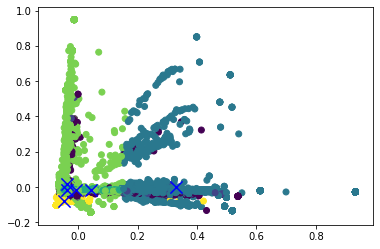

In [22]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(X_tfidf))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [23]:
reduced_cluster_centers

array([[-0.00651325, -0.01857756],
       [ 0.04352401, -0.01766478],
       [ 0.32995565,  0.00085598],
       [-0.0389861 , -0.0145092 ],
       [-0.03758645,  0.01590229],
       [-0.0481844 , -0.07749696]])

In [24]:
# Evalauation with labelled dataset
homogeneity_score(df_all.book, cls.predict(X_tfidf))

0.0018017533534770147

In [25]:
# The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
silhouette_score(X_tfidf, labels=cls.predict(X_tfidf))

0.028233007859249763

In [26]:
words = count_vect.get_feature_names()
# setup kmeans clustering
kmeans = KMeans(n_clusters = 10, n_init = 20, n_jobs = -1, tol = 0.01, max_iter = 200)
# fit the data 
kmeans.fit(X_tfidf)
# this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-10:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : like, did, don, right, went, want, thought, think, come
1 : said, colonel, pop, brett, right, mike, don, girl, man
2 : good, said, night, bye, colonel, pretty, time, feel, day
3 : town, dark, walked, street, went, road, came, coming, saw
4 : ll, said, tell, right, come, think, colonel, pop, send
5 : asked, girl, brett, colonel, pop, mike, manuel, cohn, hogan
6 : know, don, said, did, didn, want, colonel, things, really
7 : better, love, said, true, think, colonel, girl, feel, thought
8 : thing, shot, damned, said, sort, hell, thought, like, remember
9 : yes, said, oh, colonel, sir, agreed, god, says, jack


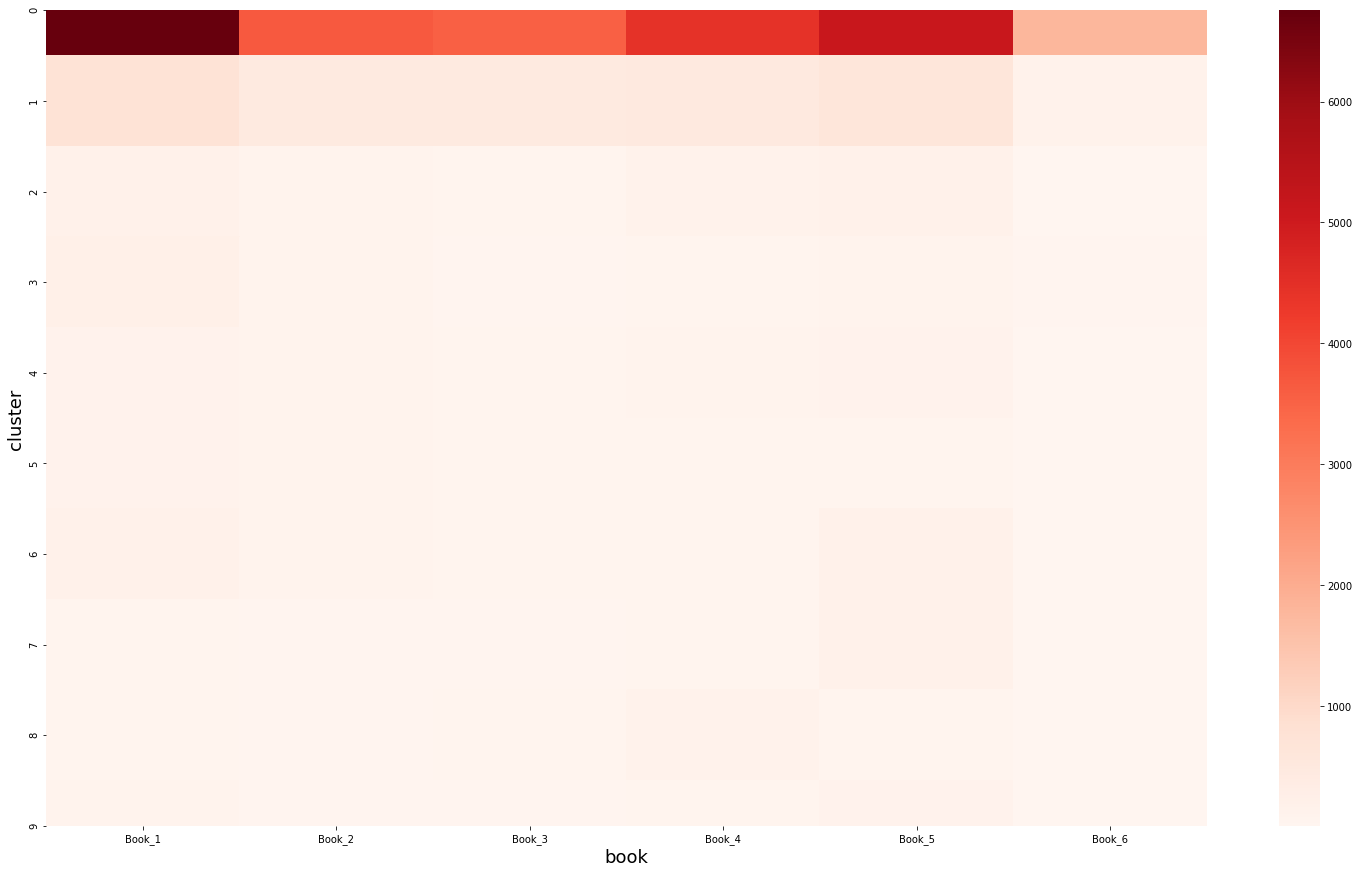

In [27]:
#add the cluster label to the data frame
df_all['cluster'] = kmeans.labels_
clusters = df_all.groupby(['cluster', 'book']).size()
fig, ax1 = plt.subplots(figsize = (26, 15))
sns.heatmap(clusters.unstack(level = 'book'), ax = ax1, cmap = 'Reds')
ax1.set_xlabel('book').set_size(18)
ax1.set_ylabel('cluster').set_size(18)